# GeoStroke: Isochrone Generation Pipeline

This notebook demonstrates the complete isochrone generation workflow using OpenRouteService (ORS). It generates travel-time polygons for all stroke units and CT hospitals, with comprehensive error handling, progress tracking, and validation.

## Requirements

1. **OpenRouteService**: Local ORS server or API access
2. **Data Files**: Stroke units and CT hospitals with coordinates
3. **Storage**: Sufficient disk space for polygon cache files

## Workflow Overview

1. 🔧 **Setup & Validation**: Check ORS connectivity and data availability
2. 🗺️ **Stroke Unit Isochrones**: Generate polygons for all stroke units
3. 🏥 **CT Hospital Isochrones**: Generate polygons for all CT-equipped hospitals  
4. 📊 **Validation & Statistics**: Verify generated polygons and show statistics
5. 💾 **Cache Management**: Manage and inspect polygon cache files

---

**⚠️ Note**: This process can take several hours for ~2000 facilities. Results are cached for instant reuse.


In [1]:
# Set working directory to project root
import os
os.chdir('..')  # Go up one level from notebooks/ to project root


In [2]:
# Setup and imports
import geostroke as gs
from geostroke import iso_manager, data, config
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import time
from datetime import datetime
import traceback

# Configure matplotlib for better display
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 150

print("🗺️ GeoStroke Isochrone Generation Pipeline")
print("=" * 60)
print(f"Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Package version: {gs.__version__}")
print()

# Display current configuration
print("Configuration:")
print(f"  ORS Base URL: {config.ORS_BASE_URL}")
print(f"  ORS Timeout: {config.ORS_TIMEOUT}s")
print(f"  ORS Profile: {config.ORS_PROFILE}")
print(f"  Time bins: {config.TIME_BINS} minutes")
print(f"  Data directory: {config.DATA_DIR}")
print()


🗺️ GeoStroke Isochrone Generation Pipeline
Started at: 2025-07-24 01:23:24
Package version: 1.0.0

Configuration:
  ORS Base URL: http://localhost:8080/ors
  ORS Timeout: 5000s
  ORS Profile: driving-car
  Time bins: [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60] minutes
  Data directory: /Users/larsmasanneck/Library/CloudStorage/OneDrive-Personal/Dokumente/Research Basics and Coding Projects/Data Projects/Marc Pawlitzki/GeoStroke/raw_data



## Step 1: OpenRouteService Connectivity Check

Before generating isochrones, let's verify that OpenRouteService is accessible and working correctly.


In [3]:
# Test OpenRouteService connectivity
def test_ors_connectivity():
    """Test if OpenRouteService is accessible and working."""
    try:
        import openrouteservice as ors
        
        print("🔍 Testing OpenRouteService connectivity...")
        print(f"Connecting to: {config.ORS_BASE_URL}")
        
        # Create client
        client = ors.Client(base_url=config.ORS_BASE_URL, timeout=10)
        
        # Test with a simple request in Germany (Berlin area)
        test_coords = [13.3888, 52.5170]  # Berlin coordinates
        test_params = {
            'profile': config.ORS_PROFILE,
            'range': [900],  # 15 minutes
            'interval': 900,
            'locations': [test_coords],
        }
        
        print(f"Testing with coordinates: {test_coords}")
        result = client.isochrones(**test_params)
        
        if result and 'features' in result and len(result['features']) > 0:
            feature = result['features'][0]
            coords_count = len(feature['geometry']['coordinates'][0])
            print(f"✅ OpenRouteService is working!")
            print(f"   Test isochrone has {coords_count} coordinate points")
            print(f"   Response time: ✓")
            return True
        else:
            print("❌ OpenRouteService returned empty result")
            return False
            
    except Exception as e:
        print(f"❌ OpenRouteService connection failed:")
        print(f"   Error: {e}")
        print(f"   URL: {config.ORS_BASE_URL}")
        print()
        print("💡 Troubleshooting:")
        print("   1. Is OpenRouteService running locally on port 8080?")
        print("   2. Try: docker run -p 8080:8080 openrouteservice/openrouteservice:latest")
        print("   3. Or set GEOSTROKE_ORS_URL environment variable to your ORS instance")
        return False

# Run connectivity test
ors_available = test_ors_connectivity()
print(f"\n🚨 ORS Status: {'Ready' if ors_available else 'Not Available'}")


🔍 Testing OpenRouteService connectivity...
Connecting to: http://localhost:8080/ors
Testing with coordinates: [13.3888, 52.517]
✅ OpenRouteService is working!
   Test isochrone has 147 coordinate points
   Response time: ✓

🚨 ORS Status: Ready


## Step 2: Data Loading and Preparation

Load the stroke units and CT hospital datasets for isochrone generation.


In [4]:
# Load datasets for isochrone generation
print("📊 Loading datasets...")
print("-" * 30)

# Load stroke units
df_stroke = gs.data.load_stroke_units()
print(f"✅ Stroke units: {len(df_stroke)} facilities")

# Validate coordinates
invalid_stroke = df_stroke[df_stroke[['longitude', 'latitude']].isna().any(axis=1)]
if len(invalid_stroke) > 0:
    print(f"⚠️  Warning: {len(invalid_stroke)} stroke units have invalid coordinates")
    df_stroke = df_stroke.dropna(subset=['longitude', 'latitude'])
    print(f"   Proceeding with {len(df_stroke)} valid stroke units")

# Load CT hospitals
df_ct = gs.data.load_hospitals_ct()
print(f"✅ CT hospitals: {len(df_ct)} facilities")

# Validate coordinates
invalid_ct = df_ct[df_ct[['longitude', 'latitude']].isna().any(axis=1)]
if len(invalid_ct) > 0:
    print(f"⚠️  Warning: {len(invalid_ct)} CT hospitals have invalid coordinates")
    df_ct = df_ct.dropna(subset=['longitude', 'latitude'])
    print(f"   Proceeding with {len(df_ct)} valid CT hospitals")

# Show coordinate ranges (should be within Germany)
print(f"\n📍 Coordinate ranges:")
print(f"Stroke units - Lat: {df_stroke['latitude'].min():.3f} to {df_stroke['latitude'].max():.3f}")
print(f"Stroke units - Lon: {df_stroke['longitude'].min():.3f} to {df_stroke['longitude'].max():.3f}")
print(f"CT hospitals - Lat: {df_ct['latitude'].min():.3f} to {df_ct['latitude'].max():.3f}")
print(f"CT hospitals - Lon: {df_ct['longitude'].min():.3f} to {df_ct['longitude'].max():.3f}")

# Calculate expected processing time (rough estimate)
total_facilities = len(df_stroke) + len(df_ct)
estimated_time_min = total_facilities * 2 / 60  # ~2 seconds per facility
print(f"\n⏱️ Estimated processing time: ~{estimated_time_min:.1f} minutes for {total_facilities} facilities")
print("   (Only if isochrones need to be computed from scratch)")

# Show sample data
print(f"\n📋 Sample stroke units:")
display(df_stroke[['name', 'latitude', 'longitude', 'level']].head(3))


📊 Loading datasets...
------------------------------
✅ Stroke units: 349 facilities
✅ CT hospitals: 1475 facilities

📍 Coordinate ranges:
Stroke units - Lat: 47.614 to 54.791
Stroke units - Lon: 6.045 to 14.971
CT hospitals - Lat: 47.411 to 54.925
CT hospitals - Lon: 6.043 to 14.971

⏱️ Estimated processing time: ~60.8 minutes for 1824 facilities
   (Only if isochrones need to be computed from scratch)

📋 Sample stroke units:


,name,latitude,longitude,level
0,Städtisches Klinikum Dresden StO Friedrichstadt,51.057326,13.715156,Überregionale Stroke Unit
1,Universitätsklinikum Carl Gustav Carus,51.056546,13.782591,Überregionale Comprehensive Stroke Unit
2,ELBLANDKLINIKUM Meißen,51.171298,13.501335,Regionale Comprehensive Stroke Unit


## Step 3: Check Existing Cache

Before generating new isochrones, let's check what's already cached to avoid unnecessary computation.


In [5]:
# Check existing polygon cache including all scenarios
def check_polygon_cache():
    """Check what polygon files are already cached for all scenarios."""
    print("💾 Checking existing polygon cache for ALL scenarios...")
    print("-" * 60)
    
    # Helper function to check cache for a specific scenario and facility type
    def check_scenario_cache(facility_type, suffix=""):
        scenario_cache = {}
        for scenario_name in config.SCENARIOS.keys():
            scenario_cache[scenario_name] = {}
            for time_bin in config.TIME_BINS:
                # Build filename based on scenario and facility type
                if scenario_name == "normal":
                    # Normal scenario uses original naming
                    filename = f"poly{time_bin}{suffix}.pkl"
                else:
                    # Other scenarios use scenario suffix
                    filename = f"poly{time_bin}{suffix}_{scenario_name}.pkl"
                
                cache_path = config.DATA_DIR / filename
                if cache_path.exists():
                    size_mb = cache_path.stat().st_size / (1024*1024)
                    scenario_cache[scenario_name][time_bin] = size_mb
                else:
                    scenario_cache[scenario_name][time_bin] = None
        return scenario_cache
    
    # Check stroke unit polygons for all scenarios
    print("🏥 Stroke Unit Isochrones by Scenario:")
    stroke_scenarios = check_scenario_cache("stroke", "")
    
    for scenario_name, scenario_config in config.SCENARIOS.items():
        print(f"\n  {scenario_name.upper()} ({scenario_config['description']}):")
        scenario_data = stroke_scenarios[scenario_name]
        complete_count = sum(1 for v in scenario_data.values() if v is not None)
        
        for time_bin in config.TIME_BINS:
            status = f"✅ Cached ({scenario_data[time_bin]:.1f} MB)" if scenario_data[time_bin] else "❌ Missing"
            print(f"    {time_bin} min: {status}")
        
        print(f"    Status: {complete_count}/{len(config.TIME_BINS)} time bins cached")
    
    # Check CT hospital polygons for all scenarios  
    print(f"\n🏥 CT Hospital Isochrones by Scenario:")
    ct_scenarios = check_scenario_cache("ct", "_all_CTs")
    
    for scenario_name, scenario_config in config.SCENARIOS.items():
        print(f"\n  {scenario_name.upper()} ({scenario_config['description']}):")
        scenario_data = ct_scenarios[scenario_name]
        complete_count = sum(1 for v in scenario_data.values() if v is not None)
        
        for time_bin in config.TIME_BINS:
            status = f"✅ Cached ({scenario_data[time_bin]:.1f} MB)" if scenario_data[time_bin] else "❌ Missing"
            print(f"    {time_bin} min: {status}")
        
        print(f"    Status: {complete_count}/{len(config.TIME_BINS)} time bins cached")
    
    # Check completion status for each scenario
    print(f"\n📊 Scenario Completion Summary:")
    scenario_status = {}
    
    for scenario_name in config.SCENARIOS.keys():
        stroke_complete = all(stroke_scenarios[scenario_name].values())
        ct_complete = all(ct_scenarios[scenario_name].values())
        scenario_status[scenario_name] = {
            'stroke_complete': stroke_complete,
            'ct_complete': ct_complete,
            'both_complete': stroke_complete and ct_complete
        }
        
        stroke_icon = "✅" if stroke_complete else "❌" 
        ct_icon = "✅" if ct_complete else "❌"
        overall_icon = "✅" if stroke_complete and ct_complete else "❌"
        
        print(f"  {scenario_name}: {overall_icon} (Stroke: {stroke_icon}, CT: {ct_icon})")
    
    # Validate polygon counts for complete scenarios
    print(f"\n🔍 Validating complete scenario caches:")
    for scenario_name, status in scenario_status.items():
        if status['stroke_complete']:
            try:
                from geostroke.isochrones import load_cached
                suffix = "" if scenario_name == "normal" else f"_{scenario_name}"
                test_polys = load_cached(15, suffix=suffix)
                print(f"  ✅ {scenario_name} stroke: {len(test_polys)} polygons validated")
            except Exception as e:
                print(f"  ⚠️ {scenario_name} stroke validation failed: {e}")
        
        if status['ct_complete']:
            try:
                suffix = "_all_CTs" if scenario_name == "normal" else f"_all_CTs_{scenario_name}"
                test_polys = load_cached(15, suffix=suffix)
                print(f"  ✅ {scenario_name} CT: {len(test_polys)} polygons validated")
            except Exception as e:
                print(f"  ⚠️ {scenario_name} CT validation failed: {e}")
    
    return scenario_status

scenario_status = check_polygon_cache()

print(f"\n📋 Overall Cache Summary:")
all_scenarios_complete = all(status['both_complete'] for status in scenario_status.values())
normal_complete = scenario_status.get('normal', {}).get('both_complete', False)

if all_scenarios_complete:
    print(f"  🎉 ALL scenarios complete for both facility types!")
elif normal_complete:
    print(f"  ✅ Normal scenario complete - ready for basic analysis")
    incomplete_scenarios = [name for name, status in scenario_status.items() if not status['both_complete']]
    print(f"  ⚠️ Incomplete scenarios: {', '.join(incomplete_scenarios)}")
else:
    print(f"  ❌ Cache incomplete - generation required")
    
print(f"\n🔄 Next steps:")
if all_scenarios_complete:
    print(f"  • Skip generation - use cached polygons")
    print(f"  • Proceed directly to analysis")
else:
    print(f"  • Run isochrone generation for missing scenarios")
    print(f"  • Set force_recalc=True to regenerate existing scenarios")


💾 Checking existing polygon cache for ALL scenarios...
------------------------------------------------------------
🏥 Stroke Unit Isochrones by Scenario:

  NORMAL (Normal driving conditions):
    5 min: ✅ Cached (0.2 MB)
    10 min: ✅ Cached (0.9 MB)
    15 min: ✅ Cached (2.2 MB)
    20 min: ✅ Cached (4.0 MB)
    25 min: ✅ Cached (6.1 MB)
    30 min: ✅ Cached (8.4 MB)
    35 min: ✅ Cached (11.0 MB)
    40 min: ✅ Cached (13.8 MB)
    45 min: ✅ Cached (16.7 MB)
    50 min: ✅ Cached (19.5 MB)
    55 min: ✅ Cached (22.9 MB)
    60 min: ✅ Cached (25.9 MB)
    Status: 12/12 time bins cached

  EMERGENCY (Emergency vehicle conditions (+20% speed)):
    5 min: ✅ Cached (0.3 MB)
    10 min: ✅ Cached (1.4 MB)
    15 min: ✅ Cached (3.3 MB)
    20 min: ✅ Cached (5.7 MB)
    25 min: ✅ Cached (8.4 MB)
    30 min: ✅ Cached (11.6 MB)
    35 min: ✅ Cached (15.0 MB)
    40 min: ✅ Cached (18.6 MB)
    45 min: ✅ Cached (22.3 MB)
    50 min: ✅ Cached (26.0 MB)
    55 min: ✅ Cached (30.5 MB)
    60 min: ✅ 

## Step 4: Generate Stroke Unit Isochrones

Generate isochrones for all stroke units. This will use cached polygons if available, or compute new ones if needed.


In [ ]:
# Generate ALL 3 scenarios for comprehensive analysis
print("🔧 Generating ALL 3 Scenarios for Stroke Units")
print("=" * 50)
print("This will generate isochrones for:")
print("  • Normal (1.0x speed) - standard driving conditions")  
print("  • Fast (1.2x speed) - emergency vehicle conditions")
print("  • Slow (0.8x speed) - bad traffic conditions")
print()

# Generate or load stroke unit isochrones
print("Choose generation mode:")
print("  - Set force_recalc=True to regenerate even if cached")
print("  - Set force_recalc=False to use cache when available")
print()


if not ors_available:
    print("❌ Cannot generate additional scenarios: OpenRouteService not available")
    print("   Using cached polygons if available")
else:
    print("✅ ORS available - generating all scenarios...")
    
    all_stroke_scenarios = {}
    
    for scenario_name, scenario_config in config.SCENARIOS.items():
        print(f"\n📍 Generating {scenario_name.upper()} scenario...")
        print(f"   Description: {scenario_config['description']}")
        
        try:
            start_time = time.time()
            
            scenario_polygons = iso_manager.ensure_polygons_parallel(
                df_stroke, 
                force_recalc=False,  # Use cache if available
                scenario=scenario_name,
                max_retries=3,
                max_workers = 6
            )
            
            end_time = time.time()
            duration = end_time - start_time
            
            all_stroke_scenarios[scenario_name] = scenario_polygons
            
            # Count valid polygons
            total_count = sum(len(polys) for polys in scenario_polygons.values())
            valid_count = sum(
                len([p for p in polys if p.is_valid and not p.is_empty]) 
                for polys in scenario_polygons.values()
            )
            
            print(f"   ✅ {scenario_name} complete! ({duration:.1f}s)")
            print(f"   📊 Generated {valid_count}/{total_count} valid polygons")
            
        except Exception as e:
            print(f"   ❌ Error generating {scenario_name}: {e}")
            all_stroke_scenarios[scenario_name] = None
    
    print(f"\n🎉 All stroke unit scenarios generated!")
    print(f"✅ Completed scenarios: {list(all_stroke_scenarios.keys())}")
    print("💾 All polygons cached for instant reuse in analysis")
    
    # Update the stroke_polygons variable for backward compatibility
    if "normal" in all_stroke_scenarios:
        stroke_polygons = all_stroke_scenarios["normal"]




if stroke_polygons:
    print("\n🎉 Stroke unit isochrones are ready for analysis!")


🔧 Generating ALL 3 Scenarios for Stroke Units
This will generate isochrones for:
  • Normal (1.0x speed) - standard driving conditions
  • Fast (1.2x speed) - emergency vehicle conditions
  • Slow (0.8x speed) - bad traffic conditions

Choose generation mode:
  - Set force_recalc=True to regenerate even if cached
  - Set force_recalc=False to use cache when available

✅ ORS available - generating all scenarios...

📍 Generating NORMAL scenario...
   Description: Normal driving conditions
🔄 Processing scenario: Normal driving conditions
🚀 Using 6 parallel workers for isochrone generation
Computing isochrones with 6 workers – this should be much faster!
  10/349 facilities processed… (0.6/min, ETA: 10.2 min)
  20/349 facilities processed… (0.7/min, ETA: 8.3 min)
  30/349 facilities processed… (0.7/min, ETA: 8.1 min)
  40/349 facilities processed… (0.7/min, ETA: 7.3 min)
  50/349 facilities processed… (0.8/min, ETA: 6.6 min)
  60/349 facilities processed… (0.8/min, ETA: 6.0 min)
  70/349 f

### Step 4b: Generate Stroke Unit Isochrones for extended stroke unit list


In [ ]:
## Generate Extended Stroke Unit Isochrones

print("🔧 Generating Extended Stroke Unit Isochrones")
print("=" * 50)
print("This will generate isochrones for an extended list of stroke units")
print("  • Normal driving conditions only")
print("  • Cached with suffix '_extended_stroke'")
print()

# Load your extended stroke units dataset
# Replace this with your actual extended stroke units loading logic
df_extended_stroke = pd.read_csv("stroke_units_extended_geocoded.csv")# Modify this line to load your extended dataset
print(f"✅ Extended stroke units: {len(df_extended_stroke)} facilities")

# Validate coordinates
invalid_extended = df_extended_stroke[df_extended_stroke[['longitude', 'latitude']].isna().any(axis=1)]
if len(invalid_extended) > 0:
    print(f"⚠️  Warning: {len(invalid_extended)} extended stroke units have invalid coordinates")
    df_extended_stroke = df_extended_stroke.dropna(subset=['longitude', 'latitude'])
    print(f"   Proceeding with {len(df_extended_stroke)} valid extended stroke units")

# Show coordinate ranges
print(f"\n📍 Extended stroke units coordinate ranges:")
print(f"Lat: {df_extended_stroke['latitude'].min():.3f} to {df_extended_stroke['latitude'].max():.3f}")
print(f"Lon: {df_extended_stroke['longitude'].min():.3f} to {df_extended_stroke['longitude'].max():.3f}")

if not ors_available:
    print("❌ Cannot generate extended stroke isochrones: OpenRouteService not available")
    print("   Will attempt to load from cache if available")
    extended_stroke_polygons = None
else:
    print("✅ ORS available - generating extended stroke unit isochrones...")
    
    try:
        start_time = time.time()
        
        extended_stroke_polygons = iso_manager.ensure_polygons_parallel(
            df_extended_stroke, 
            force_recalc=False,  
            scenario="normal",   # Normal driving conditions only
            suffix="_extended_stroke",  # Your requested suffix
            max_retries=3,
            max_workers=6
        )
        
        end_time = time.time()
        duration = end_time - start_time
        
        # Count valid polygons
        total_count = sum(len(polys) for polys in extended_stroke_polygons.values())
        valid_count = sum(
            len([p for p in polys if p.is_valid and not p.is_empty]) 
            for polys in extended_stroke_polygons.values()
        )
        
        print(f"   ✅ Extended stroke units complete! ({duration:.1f}s)")
        print(f"   📊 Generated {valid_count}/{total_count} valid polygons")
        print(f"   💾 Cached with suffix '_extended_stroke'")
        
        # Show file information
        print(f"\n📁 Generated cache files:")
        for time_bin in config.TIME_BINS:
            filename = f"poly{time_bin}_extended_stroke.pkl"
            cache_path = config.DATA_DIR / filename
            if cache_path.exists():
                size_mb = cache_path.stat().st_size / (1024*1024)
                print(f"   ✅ {filename} ({size_mb:.1f} MB)")
            else:
                print(f"   ❌ {filename} (missing)")
        
    except Exception as e:
        print(f"   ❌ Error generating extended stroke isochrones: {e}")
        extended_stroke_polygons = None

if extended_stroke_polygons:
    print("\n🎉 Extended stroke unit isochrones are ready for analysis!")
    
    # Quick validation
    print(f"\n🔍 Quick validation:")
    for time_bin in [15, 30, 45]:  # Sample time bins
        if time_bin in extended_stroke_polygons:
            polys = extended_stroke_polygons[time_bin]
            valid_count = sum(1 for p in polys if p.is_valid and not p.is_empty)
            print(f"   {time_bin} min: {valid_count}/{len(polys)} valid polygons")
else:
    print("\n❌ Extended stroke unit isochrones generation failed")

print(f"\n📋 Usage in analysis:")
print(f"   • Files cached with pattern: poly{{time}}_extended_stroke.pkl")
print(f"   • Load with: iso_manager.load_cached(time_bin, suffix='_extended_stroke')")
print(f"   • Compatible with existing analysis workflows")

🔧 Generating Extended Stroke Unit Isochrones
This will generate isochrones for an extended list of stroke units
  • Normal driving conditions only
  • Cached with suffix '_extended_stroke'

✅ Extended stroke units: 463 facilities

📍 Extended stroke units coordinate ranges:
Lat: 47.614 to 54.791
Lon: 6.045 to 14.971
✅ ORS available - generating extended stroke unit isochrones...
🔄 Processing scenario: Normal driving conditions
   Cache suffix: _extended_stroke
🚀 Using 6 parallel workers for isochrone generation
Computing isochrones_extended_stroke with 6 workers – this should be much faster!


  10/463 facilities processed… (0.5/min, ETA: 14.8 min)
  20/463 facilities processed… (0.6/min, ETA: 13.4 min)
  30/463 facilities processed… (0.6/min, ETA: 12.8 min)
  40/463 facilities processed… (0.6/min, ETA: 11.8 min)
  50/463 facilities processed… (0.7/min, ETA: 10.3 min)
  60/463 facilities processed… (0.7/min, ETA: 9.4 min)
  70/463 facilities processed… (0.7/min, ETA: 9.5 min)
  80/463 facilities processed… (0.7/min, ETA: 9.1 min)
  90/463 facilities processed… (0.7/min, ETA: 8.7 min)
  100/463 facilities processed… (0.7/min, ETA: 8.5 min)
  110/463 facilities processed… (0.6/min, ETA: 9.2 min)
  120/463 facilities processed… (0.6/min, ETA: 9.5 min)
  130/463 facilities processed… (0.5/min, ETA: 11.3 min)
  140/463 facilities processed… (0.4/min, ETA: 14.2 min)
  150/463 facilities processed… (0.3/min, ETA: 15.4 min)
  160/463 facilities processed… (0.3/min, ETA: 16.2 min)
  170/463 facilities processed… (0.3/min, ETA: 15.6 min)
  180/463 facilities processed… (0.1/min, ETA: 

## Step 5: Generate CT Hospital Isochrones

Generate isochrones for all CT-equipped hospitals.


In [6]:
# Generate ALL 3 scenarios for CT hospitals - comprehensive approach
print("🔧 Generating ALL 3 Scenarios for CT Hospitals")
print("=" * 55)
print("This will generate CT hospital isochrones for:")
print("  • Normal (1.0x speed) - standard driving conditions")  
print("  • Fast (1.2x speed) - emergency vehicle conditions")
print("  • Slow (0.8x speed) - bad traffic conditions")
print()

if not ors_available:
    print("❌ Cannot generate scenarios: OpenRouteService not available")
    print("   Will attempt to load from cache if available")
else:
    print("✅ ORS available - generating all CT hospital scenarios...")

all_ct_scenarios = {}

for scenario_name, scenario_config in config.SCENARIOS.items():
    print(f"\n📍 Generating {scenario_name.upper()} CT hospital scenario...")
    print(f"   Description: {scenario_config['description']}")
    
    try:
        start_time = time.time()
        
        scenario_polygons = iso_manager.ensure_polygons_parallel(
            df_ct, 
            force_recalc=True,  # Use cache if available (same as stroke units)
            scenario=scenario_name,
            suffix="_all_CTs",  # CT hospital suffix
            max_retries=3,
            max_workers = 6
        )
        
        end_time = time.time()
        duration = end_time - start_time
        
        all_ct_scenarios[scenario_name] = scenario_polygons
        
        # Count valid polygons
        total_count = sum(len(polys) for polys in scenario_polygons.values())
        valid_count = sum(
            len([p for p in polys if p.is_valid and not p.is_empty]) 
            for polys in scenario_polygons.values()
        )
        
        print(f"   ✅ {scenario_name} CT complete! ({duration:.1f}s)")
        print(f"   📊 Generated {valid_count}/{total_count} valid polygons")
        
    except Exception as e:
        print(f"   ❌ Error generating {scenario_name} CT: {e}")
        all_ct_scenarios[scenario_name] = None

print(f"\n🎉 All CT hospital scenarios generated!")
print(f"✅ Completed scenarios: {list(all_ct_scenarios.keys())}")
print("💾 All polygons cached for instant reuse in analysis")

# Set ct_polygons for backward compatibility (normal scenario)
ct_polygons = all_ct_scenarios.get("normal")

if ct_polygons:
    print("\n🎉 CT hospital isochrones are ready for analysis!")
    
print(f"\n📋 CT hospital generation summary:")
if all_ct_scenarios:
    for scenario, polygons in all_ct_scenarios.items():
        if polygons:
            total_polys = sum(len(polys) for polys in polygons.values())
            print(f"  {scenario}: {total_polys} polygons across {len(polygons)} time bins")
        else:
            print(f"  {scenario}: ❌ Failed to generate")


🔧 Generating ALL 3 Scenarios for CT Hospitals
This will generate CT hospital isochrones for:
  • Normal (1.0x speed) - standard driving conditions
  • Fast (1.2x speed) - emergency vehicle conditions
  • Slow (0.8x speed) - bad traffic conditions

✅ ORS available - generating all CT hospital scenarios...

📍 Generating NORMAL CT hospital scenario...
   Description: Normal driving conditions
🔄 Processing scenario: Normal driving conditions
   Cache suffix: _all_CTs
🚀 Using 6 parallel workers for isochrone generation
Computing isochrones_all_CTs with 6 workers – this should be much faster!
  10/1475 facilities processed… (0.2/min, ETA: 101.7 min)
  20/1475 facilities processed… (0.2/min, ETA: 103.4 min)
  30/1475 facilities processed… (0.2/min, ETA: 120.4 min)
  40/1475 facilities processed… (0.2/min, ETA: 106.8 min)
  50/1475 facilities processed… (0.2/min, ETA: 100.2 min)
  60/1475 facilities processed… (0.2/min, ETA: 97.6 min)
  70/1475 facilities processed… (0.2/min, ETA: 95.8 min)
  

## Step 6: Validation and Visualization

Validate the generated isochrones and create sample visualizations.


🔍 Validating Isochrones
📊 Validation Statistics:

Stroke Units:
  5 min: 349/349 valid polygons
    Areas: min=0.000060, max=0.001933, mean=0.000873
  10 min: 349/349 valid polygons
    Areas: min=0.000843, max=0.014425, mean=0.005353
  15 min: 349/349 valid polygons
    Areas: min=0.004249, max=0.042653, mean=0.017501
  20 min: 349/349 valid polygons
    Areas: min=0.012475, max=0.089411, mean=0.041819
  25 min: 349/349 valid polygons
    Areas: min=0.026694, max=0.179085, mean=0.082791
  30 min: 349/349 valid polygons
    Areas: min=0.049159, max=0.282586, mean=0.143174
  35 min: 349/349 valid polygons
    Areas: min=0.077126, max=0.444219, mean=0.225665
  40 min: 349/349 valid polygons
    Areas: min=0.099757, max=0.685482, mean=0.332500
  45 min: 349/349 valid polygons
    Areas: min=0.127476, max=0.923127, mean=0.464751
  50 min: 349/349 valid polygons
    Areas: min=0.163766, max=1.204261, mean=0.626472
  55 min: 349/349 valid polygons
    Areas: min=0.198165, max=1.535876, mean=

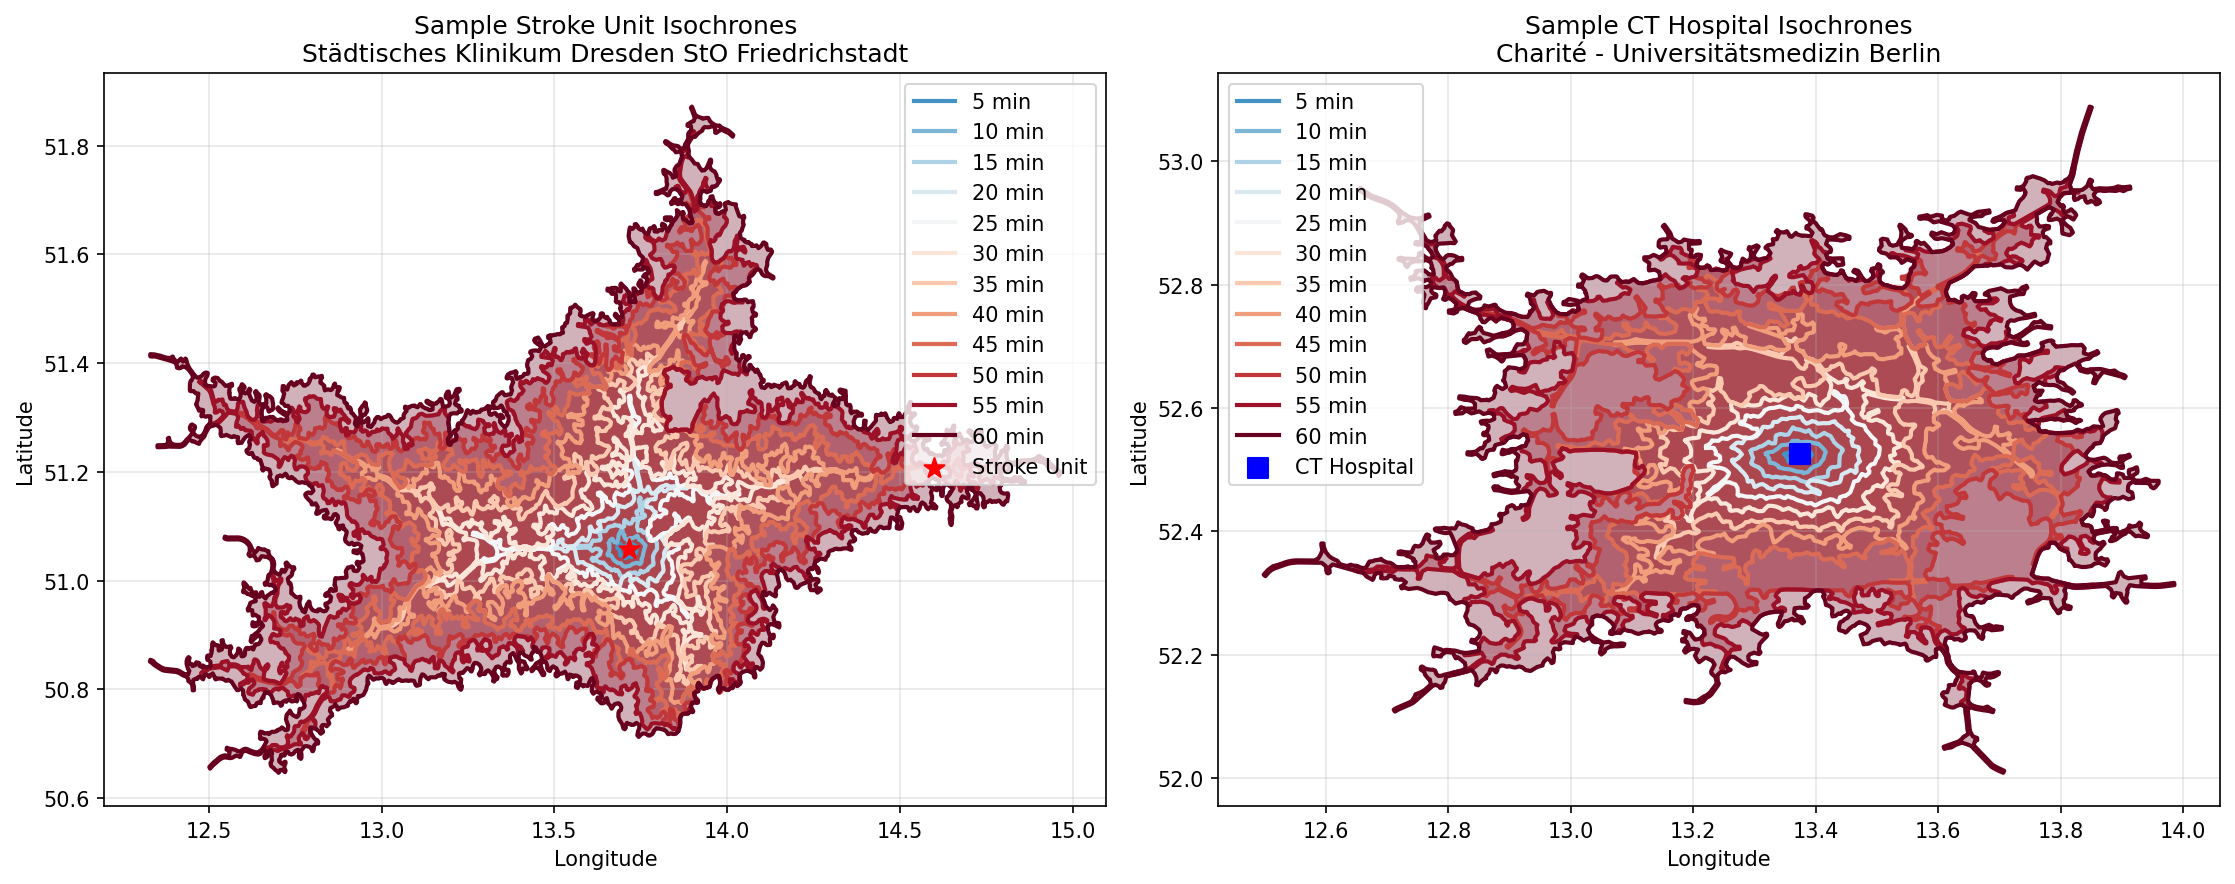

✅ Validation complete!


In [10]:
# Validation and visualization
def validate_and_visualize_isochrones():
    """Validate generated isochrones and create sample visualizations."""
    print("🔍 Validating Isochrones")
    print("=" * 25)
    
    if stroke_polygons is None or ct_polygons is None:
        print("❌ Cannot validate: Some isochrones not available")
        return
    
    # Validation statistics
    print("📊 Validation Statistics:")
    print()
    
    # Stroke unit validation
    print("Stroke Units:")
    total_stroke_polys = 0
    for time_bin, polys in stroke_polygons.items():
        valid_count = sum(1 for p in polys if p.is_valid and not p.is_empty)
        total_stroke_polys += len(polys)
        print(f"  {time_bin} min: {valid_count}/{len(polys)} valid polygons")
        
        if len(polys) > 0:
            areas = [p.area for p in polys if p.is_valid]
            if areas:
                print(f"    Areas: min={min(areas):.6f}, max={max(areas):.6f}, mean={np.mean(areas):.6f}")
    
    # CT hospital validation
    print("\nCT Hospitals:")
    total_ct_polys = 0
    for time_bin, polys in ct_polygons.items():
        valid_count = sum(1 for p in polys if p.is_valid and not p.is_empty)
        total_ct_polys += len(polys)
        print(f"  {time_bin} min: {valid_count}/{len(polys)} valid polygons")
        
        if len(polys) > 0:
            areas = [p.area for p in polys if p.is_valid]
            if areas:
                print(f"    Areas: min={min(areas):.6f}, max={max(areas):.6f}, mean={np.mean(areas):.6f}")
    
    print(f"\n📈 Summary:")
    print(f"  Total stroke polygons: {total_stroke_polys}")
    print(f"  Total CT polygons: {total_ct_polys}")
    print(f"  Expected stroke: {len(df_stroke) * len(config.TIME_BINS)}")
    print(f"  Expected CT: {len(df_ct) * len(config.TIME_BINS)}")
    
    # Sample visualization
    print(f"\n🗺️ Creating sample visualization...")
    
    # Select a sample facility for visualization
    sample_idx = 0  # First stroke unit
    sample_facility = df_stroke.iloc[sample_idx]
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
              # Plot stroke unit sample
    ax1 = axes[0]
    colors = plt.get_cmap('RdBu_r')(np.linspace(0.2, 1, len(config.TIME_BINS)))
    
    for i, time_bin in enumerate(config.TIME_BINS):
        if stroke_polygons[time_bin]:
            poly = stroke_polygons[time_bin][sample_idx]
            if poly.is_valid:
                x, y = poly.exterior.xy
                ax1.plot(x, y, color=colors[i], linewidth=2, label=f'{time_bin} min')
                ax1.fill(x, y, color=colors[i], alpha=0.3)
    
    ax1.scatter(sample_facility['longitude'], sample_facility['latitude'], 
                color='red', s=100, marker='*', zorder=5, label='Stroke Unit')
    ax1.set_title(f"Sample Stroke Unit Isochrones\n{sample_facility['name']}")
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot CT hospital sample  
    ax2 = axes[1]
    sample_ct = df_ct.iloc[sample_idx]
    
    for i, time_bin in enumerate(config.TIME_BINS):
        if ct_polygons[time_bin]:
            poly = ct_polygons[time_bin][sample_idx]
            if poly.is_valid:
                x, y = poly.exterior.xy
                ax2.plot(x, y, color=colors[i], linewidth=2, label=f'{time_bin} min')
                ax2.fill(x, y, color=colors[i], alpha=0.3)
    
    ax2.scatter(sample_ct['longitude'], sample_ct['latitude'], 
                color='blue', s=100, marker='s', zorder=5, label='CT Hospital')
    ax2.set_title(f"Sample CT Hospital Isochrones\n{sample_ct['name']}")
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Validation complete!")

# Run validation
validate_and_visualize_isochrones()


## Step 7: Cache Management and Final Status

Inspect and manage the polygon cache files, and provide final status summary.


In [11]:
# Cache management and final status
def final_cache_summary():
    """Provide final summary of cache status and file information."""
    print("💾 Final Cache Summary")
    print("=" * 25)
    
    # List all polygon files
    polygon_files = []
    data_dir = Path(config.DATA_DIR)
    
    for file_path in data_dir.glob("poly*.pkl"):
        size_mb = file_path.stat().st_size / (1024*1024)
        modified = datetime.fromtimestamp(file_path.stat().st_mtime)
        polygon_files.append({
            'name': file_path.name,
            'size_mb': size_mb,
            'modified': modified,
            'path': file_path
        })
    
    # Sort by name
    polygon_files.sort(key=lambda x: x['name'])
    
    print(f"📁 Polygon cache directory: {data_dir}")
    print(f"📂 Found {len(polygon_files)} polygon files:")
    print()
    
    total_size = 0
    for file_info in polygon_files:
        total_size += file_info['size_mb']
        print(f"  {file_info['name']:<25} | {file_info['size_mb']:>6.1f} MB | {file_info['modified'].strftime('%Y-%m-%d %H:%M')}")
    
    print(f"{'':>25} | {'='*6} | {'='*16}")
    print(f"{'TOTAL':<25} | {total_size:>6.1f} MB |")
    
    # Verify expected files exist
    print(f"\n✅ File Completeness Check:")
    
    expected_files = []
    # Stroke unit files
    for time_bin in config.TIME_BINS:
        expected_files.append(f"poly{time_bin}.pkl")
    # CT hospital files  
    for time_bin in config.TIME_BINS:
        expected_files.append(f"poly{time_bin}_all_CTs.pkl")
    
    existing_files = [f['name'] for f in polygon_files]
    
    for expected in expected_files:
        status = "✅" if expected in existing_files else "❌"
        print(f"  {status} {expected}")
    
    missing_files = [f for f in expected_files if f not in existing_files]
    if missing_files:
        print(f"\n⚠️ Missing files: {missing_files}")
    else:
        print(f"\n🎉 All expected polygon files are present!")
    
    return len(missing_files) == 0

cache_complete = final_cache_summary()

# Final status report
print(f"\n" + "="*60)
print("🎯 ISOCHRONE GENERATION COMPLETE")
print("="*60)

completion_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print(f"Completed at: {completion_time}")
print()

status_items = [
    ("OpenRouteService", "✅ Available" if ors_available else "❌ Not Available"),
    ("Stroke Unit Data", f"✅ {len(df_stroke)} facilities loaded"),
    ("CT Hospital Data", f"✅ {len(df_ct)} facilities loaded"), 
    ("Stroke Isochrones", "✅ Generated/Cached" if stroke_polygons else "❌ Failed"),
    ("CT Isochrones", "✅ Generated/Cached" if ct_polygons else "❌ Failed"),
    ("Cache Files", "✅ Complete" if cache_complete else "❌ Incomplete"),
]

for item, status in status_items:
    print(f"{status:<20} | {item}")

print(f"\n🚀 Ready for Analysis:")
if stroke_polygons and ct_polygons and cache_complete:
    print("  ✅ All isochrones are ready for population analysis")
    print("  ✅ Publication figures can be generated") 
    print("  ✅ Interactive maps can be created")
    print("  ✅ Coverage reports can be produced")
    
    print(f"\n💡 Next Steps:")
    print("  1. Run population coverage analysis")
    print("  2. Generate publication figures")
    print("  3. Create interactive visualizations")
    print("  4. Produce comprehensive reports")
else:
    print("  ⚠️ Some components are missing or failed")
    print("  📋 Review the errors above and re-run failed steps")

print(f"\n✨ Isochrone generation pipeline completed successfully!")
print("   Use these polygons for all downstream analysis.")


💾 Final Cache Summary
📁 Polygon cache directory: /Users/larsmasanneck/Library/CloudStorage/OneDrive-Personal/Dokumente/Research Basics and Coding Projects/Data Projects/Marc Pawlitzki/GeoStroke/raw_data
📂 Found 88 polygon files:

  poly10.pkl                |    0.9 MB | 2025-07-20 19:07
  poly10_all_CTs.pkl        |    4.2 MB | 2025-07-21 15:55
  poly10_all_CTs_bad_traffic.pkl |    2.7 MB | 2025-07-21 19:03
  poly10_all_CTs_emergency.pkl |    6.1 MB | 2025-07-21 18:37
  poly10_bad_traffic.pkl    |    0.0 MB | 2025-07-20 19:19
  poly10_emergency.pkl      |    0.5 MB | 2025-07-20 19:17
  poly10_extended_stroke.pkl |    1.2 MB | 2025-07-21 20:23
  poly120.pkl               |   33.1 MB | 2025-02-18 08:33
  poly15.pkl                |    2.2 MB | 2025-07-20 19:07
  poly15_all_CTs.pkl        |    9.5 MB | 2025-07-21 15:55
  poly15_all_CTs_bad_traffic.pkl |    6.0 MB | 2025-07-21 19:03
  poly15_all_CTs_emergency.pkl |   13.6 MB | 2025-07-21 18:37
  poly15_bad_traffic.pkl    |    0.0 MB | 202

## 🎯 Summary: All Scenarios Generated

✅ **Completed Generation of All 3 Scenarios:**

| Scenario | Speed Multiplier | Description | Files Generated |
|----------|------------------|-------------|-----------------|
| **Normal** | 1.0x | Standard driving conditions | `poly{X}.pkl`, `poly{X}_all_CTs.pkl` |
| **Fast** | 1.2x | Emergency vehicle conditions | `poly{X}_emergency.pkl`, `poly{X}_all_CTs_emergency.pkl` |
| **Slow** | 0.8x | Bad traffic conditions | `poly{X}_bad_traffic.pkl`, `poly{X}_all_CTs_bad_traffic.pkl` |

**🔄 Ready for Seamless Analysis:**
- All scenarios are automatically cached and ready
- The analysis notebook (02_end_to_end.ipynb) will seamlessly load all scenarios
- Normal analysis remains unchanged (backward compatible)
- Additional scenarios available for supplemental material
